In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

import pandas as pd


import tensorflow as tf
use_gpu = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

import numpy as np

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
#from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint

# tools for plotting confusion matrices
from matplotlib import pyplot as plt

import random 
import math

C:\Users\marit\Anaconda3\lib\site-packages\numba\decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [2]:
# https://github.com/DustinAlandzes/mnist-lenet-keras/blob/master/lenet.py
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense

def LeNet(nb_classes, Chans = 64, Samples = 128, Kernels=1,
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25):
    
        model = Sequential()

        # first set of CONV => RELU => POOL
        model.add(Convolution2D(20, 5, 5, border_mode="same",
            input_shape=(Kernels, Chans, Samples)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # second set of CONV => RELU => POOL
        model.add(Convolution2D(50, 5, 5, border_mode="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(nb_classes))
        model.add(Activation("softmax"))
        
   
    
        return model

Using TensorFlow backend.


In [3]:
ignore_list = ['s07']  #list of patient files that should be skipped
sample_size = 1


In [4]:
import pyedflib
mne.set_log_level("WARNING")

# get the minimum length of the files
def get_minimum_duration(group_directory_name, patient_group_file_prefix):
    file_durations = []
    for i in range (1, 15): # reading 14 files
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        file_name = '{}\\{}.edf'.format(group_directory_name, patient_id)
        f = pyedflib.EdfReader(file_name)
        file_durations.append(f.file_duration)
        f.close()
    return(min(file_durations))

# modified based on https://stackoverflow.com/a/48704557/2466781
def chunk(seq, size):
    sl = len(seq) - (len(seq)%size) #exclude values that will be out of range
    r = [pd.DataFrame(seq[pos:pos + size]) for pos in range(0, sl, size)]
    return r

# modified version of process_patient_group in older notebooks
# Uses the raw EDF files and converts to dataframe, dropping the first 150 and last 30 seconds of the shortest  file
# All other files are trimmed similarly to produce the same size
# Adapted from page 1 of https://buildmedia.readthedocs.org/media/pdf/pyedflib/latest/pyedflib.pdf
def process_patient_group(group_directory_name, patient_group_file_prefix, 
                          minimum_original_duration, 
                          plot_channels = False,
                         channels = ['F8', 'F7', 'F4', 'F3', 'Fz']):
    meta_df = pd.DataFrame()
    meta = []
    patient_id_list = []
    for i in range (1, 15): # reading 14 files
        patient_id = "{}{:02d}".format(patient_group_file_prefix, i)
        patient_id_list.append(patient_id)
        
        file_name = '{}\\{}.edf'.format(group_directory_name, patient_id)
        data = mne.io.read_raw_edf(file_name)
        df = data.to_data_frame()
        df2 = df[channels]
        ## based on visual inspection, drop the first 150 seconds
        df2 = df2[150: (minimum_original_duration-30)]
        f = pyedflib.EdfReader(file_name)
        f.close()
        if patient_id not in ignore_list:
            meta_df = meta_df.append(df2)
            
    batches = chunk(meta_df, sample_size)

    for batch in batches:
        #display(np.asarray(batch.values).shape)
        meta.append([np.asarray(batch.values)])
           
                    
    return meta
        

In [5]:
# Retrieve patient data, using a time window determined by the shortest recording
# patient s07 is removed

minimum_duration = min(get_minimum_duration("Healthy Controls", "h"), get_minimum_duration('SZ Patients', 's'))
print('minimum duration: ', minimum_duration)
print("Healthy Controls")
all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
       'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
target_channels = ['T4', 'T6', 'O2', 'T3', 'T5', 'O1',
                   'C4', 'P4', 'C3', 'P3', 'Cz', 'Pz']
hc_data = process_patient_group('Healthy Controls', 'h', minimum_duration, channels=target_channels)
display(np.asarray(hc_data).shape)


print('Sz Patients')
sz_data = np.asarray(process_patient_group('SZ Patients', 's', minimum_duration, channels=target_channels))
display(np.asarray(sz_data).shape)



sample_size = 1
kernel_size = 1

##### combine groups and create Y (labels)
X =  np.concatenate((hc_data, sz_data), axis=0)
display('Combined input size: ', X.shape)
y = ([0] * len(hc_data)) +( [1] * len(sz_data))

minimum duration:  740
Healthy Controls


(7840, 1, 1, 12)

Sz Patients


(7280, 1, 1, 12)

'Combined input size: '

(15120, 1, 1, 12)

In [6]:
# create the /tmp directory if it doesn't already exist
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')


In [7]:
# get a list of randomly selected sets of numbers based on a range
# the proportion of values selected for each set is determined by the ratio_array
def get_mixed_indexes_for_ml_train_test(length, ratios_array):
    input_indexes = range(0, length)
    output_indexes = []
    for ratio in ratios_array:
        selection = random.choices(input_indexes, k=math.floor(ratio * length))
        input_indexes = [i for i in input_indexes if i not in selection]
        output_indexes.append(selection)
    return output_indexes
    



In [8]:

kernels, chans, samples =  sample_size,  len(target_channels), kernel_size
train_idxs, validate_idxs, test_idxs = get_mixed_indexes_for_ml_train_test(len(X), [.70, 0.15, 0.15])


X_train      = X[train_idxs][0:,]
Y_train      = np.asarray(y)[train_idxs]
X_validate   = X[validate_idxs][0:,]
Y_validate   = np.asarray(y)[validate_idxs]
X_test       = X[test_idxs][0:,]
Y_test       = np.asarray(y)[test_idxs]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
Y_train      = np_utils.to_categorical(Y_train, num_classes=2)
Y_validate   = np_utils.to_categorical(Y_validate, num_classes=2)
Y_test       = np_utils.to_categorical(Y_test, num_classes=2)


# convert data to NHWC (trials, channels, samples, kernels) format.  for CPU. Data 
X_train      = X_train.reshape(X_train.shape[0],  chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples,  kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)


#temp test with kernels, chans, samples 2020-01-11
X_train      = X_train.reshape(X_train.shape[0],  kernels, chans, samples)
X_validate   = X_validate.reshape(X_validate.shape[0], kernels, chans, samples)
X_test       = X_test.reshape(X_test.shape[0], kernels, chans, samples)

 
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = LeNet(nb_classes = 2, Chans = chans, Samples = samples, Kernels=kernels,
               dropoutRate = 0.1, kernLength = 16, F1 = 8, D = 2, F2 = 16)

model.summary()

from keras import optimizers

adam = optimizers.Adam(lr=0.0000001, 
                                beta_1=0.99,
                                beta_2=0.999,
                                epsilon=1e-07)
sgd = optimizers.SGD(lr=0.01)



def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

# compile the model and set the optimizer
model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics=[#'mse', 'mae', 
                  'accuracy', rmse
                 ])

# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
checkpointer = ModelCheckpoint(filepath='/tmp/lenet_checkpoint.h5', verbose=1,
                               save_best_only=True)



X_train shape: (10584, 1, 12, 1)
10584 train samples
2268 test samples
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\marit\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(20, (5, 5), input_shape=(1, 12, 1), padding="same")`


ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_1/MaxPool' (op: 'MaxPool') with input shapes: [?,1,12,20].

In [16]:

fittedModel = model.fit(X_train, Y_train, batch_size = 32, epochs = 1500, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        callbacks=[checkpointer])#, class_weight = class_weights)

# load optimal weights
model.load_weights('/tmp/lenet_checkpoint.h5')


probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy for test set: %f " % (acc))




Train on 529 samples, validate on 113 samples
Epoch 1/1500
 - 2s - loss: 0.8278 - acc: 0.5728 - rmse: 0.5408 - val_loss: 0.8360 - val_acc: 0.5133 - val_rmse: 0.5441

Epoch 00001: val_loss improved from inf to 0.83600, saving model to /tmp/lenet_checkpoint.h5
Epoch 2/1500
 - 1s - loss: 0.8214 - acc: 0.5747 - rmse: 0.5390 - val_loss: 0.8311 - val_acc: 0.5133 - val_rmse: 0.5427

Epoch 00002: val_loss improved from 0.83600 to 0.83108, saving model to /tmp/lenet_checkpoint.h5
Epoch 3/1500
 - 1s - loss: 0.8146 - acc: 0.5728 - rmse: 0.5375 - val_loss: 0.8264 - val_acc: 0.5133 - val_rmse: 0.5414

Epoch 00003: val_loss improved from 0.83108 to 0.82638, saving model to /tmp/lenet_checkpoint.h5
Epoch 4/1500
 - 1s - loss: 0.8083 - acc: 0.5671 - rmse: 0.5355 - val_loss: 0.8219 - val_acc: 0.5221 - val_rmse: 0.5401

Epoch 00004: val_loss improved from 0.82638 to 0.82185, saving model to /tmp/lenet_checkpoint.h5
Epoch 5/1500
 - 1s - loss: 0.8021 - acc: 0.5690 - rmse: 0.5325 - val_loss: 0.8175 - val_ac


Epoch 00038: val_loss improved from 0.75314 to 0.75266, saving model to /tmp/lenet_checkpoint.h5
Epoch 39/1500
 - 1s - loss: 0.6904 - acc: 0.5293 - rmse: 0.4986 - val_loss: 0.7522 - val_acc: 0.5575 - val_rmse: 0.5180

Epoch 00039: val_loss improved from 0.75266 to 0.75221, saving model to /tmp/lenet_checkpoint.h5
Epoch 40/1500
 - 1s - loss: 0.6893 - acc: 0.5350 - rmse: 0.4987 - val_loss: 0.7518 - val_acc: 0.5487 - val_rmse: 0.5178

Epoch 00040: val_loss improved from 0.75221 to 0.75181, saving model to /tmp/lenet_checkpoint.h5
Epoch 41/1500
 - 1s - loss: 0.6881 - acc: 0.5350 - rmse: 0.4977 - val_loss: 0.7514 - val_acc: 0.5487 - val_rmse: 0.5176

Epoch 00041: val_loss improved from 0.75181 to 0.75144, saving model to /tmp/lenet_checkpoint.h5
Epoch 42/1500
 - 1s - loss: 0.6869 - acc: 0.5331 - rmse: 0.4974 - val_loss: 0.7511 - val_acc: 0.5487 - val_rmse: 0.5174

Epoch 00042: val_loss improved from 0.75144 to 0.75112, saving model to /tmp/lenet_checkpoint.h5
Epoch 43/1500
 - 1s - loss: 0.


Epoch 00076: val_loss improved from 0.74682 to 0.74671, saving model to /tmp/lenet_checkpoint.h5
Epoch 77/1500
 - 1s - loss: 0.6647 - acc: 0.5539 - rmse: 0.4892 - val_loss: 0.7466 - val_acc: 0.5310 - val_rmse: 0.5139

Epoch 00077: val_loss improved from 0.74671 to 0.74658, saving model to /tmp/lenet_checkpoint.h5
Epoch 78/1500
 - 1s - loss: 0.6643 - acc: 0.5539 - rmse: 0.4892 - val_loss: 0.7465 - val_acc: 0.5310 - val_rmse: 0.5139

Epoch 00078: val_loss improved from 0.74658 to 0.74646, saving model to /tmp/lenet_checkpoint.h5
Epoch 79/1500
 - 1s - loss: 0.6638 - acc: 0.5539 - rmse: 0.4892 - val_loss: 0.7463 - val_acc: 0.5310 - val_rmse: 0.5138

Epoch 00079: val_loss improved from 0.74646 to 0.74633, saving model to /tmp/lenet_checkpoint.h5
Epoch 80/1500
 - 1s - loss: 0.6634 - acc: 0.5539 - rmse: 0.4882 - val_loss: 0.7462 - val_acc: 0.5310 - val_rmse: 0.5137

Epoch 00080: val_loss improved from 0.74633 to 0.74621, saving model to /tmp/lenet_checkpoint.h5
Epoch 81/1500
 - 1s - loss: 0.

 - 1s - loss: 0.6501 - acc: 0.5633 - rmse: 0.4832 - val_loss: 0.7408 - val_acc: 0.5398 - val_rmse: 0.5115

Epoch 00114: val_loss improved from 0.74094 to 0.74076, saving model to /tmp/lenet_checkpoint.h5
Epoch 115/1500
 - 1s - loss: 0.6497 - acc: 0.5633 - rmse: 0.4832 - val_loss: 0.7406 - val_acc: 0.5398 - val_rmse: 0.5114

Epoch 00115: val_loss improved from 0.74076 to 0.74056, saving model to /tmp/lenet_checkpoint.h5
Epoch 116/1500
 - 1s - loss: 0.6493 - acc: 0.5633 - rmse: 0.4832 - val_loss: 0.7404 - val_acc: 0.5398 - val_rmse: 0.5114

Epoch 00116: val_loss improved from 0.74056 to 0.74037, saving model to /tmp/lenet_checkpoint.h5
Epoch 117/1500
 - 1s - loss: 0.6490 - acc: 0.5633 - rmse: 0.4827 - val_loss: 0.7402 - val_acc: 0.5398 - val_rmse: 0.5113

Epoch 00117: val_loss improved from 0.74037 to 0.74019, saving model to /tmp/lenet_checkpoint.h5
Epoch 118/1500
 - 1s - loss: 0.6486 - acc: 0.5633 - rmse: 0.4824 - val_loss: 0.7400 - val_acc: 0.5398 - val_rmse: 0.5112

Epoch 00118: val_


Epoch 00151: val_loss improved from 0.73397 to 0.73377, saving model to /tmp/lenet_checkpoint.h5
Epoch 152/1500
 - 1s - loss: 0.6364 - acc: 0.5671 - rmse: 0.4764 - val_loss: 0.7336 - val_acc: 0.5398 - val_rmse: 0.5090

Epoch 00152: val_loss improved from 0.73377 to 0.73359, saving model to /tmp/lenet_checkpoint.h5
Epoch 153/1500
 - 1s - loss: 0.6361 - acc: 0.5671 - rmse: 0.4766 - val_loss: 0.7334 - val_acc: 0.5398 - val_rmse: 0.5090

Epoch 00153: val_loss improved from 0.73359 to 0.73341, saving model to /tmp/lenet_checkpoint.h5
Epoch 154/1500
 - 1s - loss: 0.6357 - acc: 0.5671 - rmse: 0.4767 - val_loss: 0.7332 - val_acc: 0.5398 - val_rmse: 0.5089

Epoch 00154: val_loss improved from 0.73341 to 0.73322, saving model to /tmp/lenet_checkpoint.h5
Epoch 155/1500
 - 1s - loss: 0.6354 - acc: 0.5671 - rmse: 0.4764 - val_loss: 0.7330 - val_acc: 0.5398 - val_rmse: 0.5088

Epoch 00155: val_loss improved from 0.73322 to 0.73304, saving model to /tmp/lenet_checkpoint.h5
Epoch 156/1500
 - 1s - los

 - 1s - loss: 0.6245 - acc: 0.5709 - rmse: 0.4712 - val_loss: 0.7273 - val_acc: 0.5398 - val_rmse: 0.5068

Epoch 00189: val_loss improved from 0.72747 to 0.72731, saving model to /tmp/lenet_checkpoint.h5
Epoch 190/1500
 - 1s - loss: 0.6242 - acc: 0.5709 - rmse: 0.4711 - val_loss: 0.7271 - val_acc: 0.5398 - val_rmse: 0.5067

Epoch 00190: val_loss improved from 0.72731 to 0.72712, saving model to /tmp/lenet_checkpoint.h5
Epoch 191/1500
 - 1s - loss: 0.6239 - acc: 0.5709 - rmse: 0.4709 - val_loss: 0.7269 - val_acc: 0.5398 - val_rmse: 0.5067

Epoch 00191: val_loss improved from 0.72712 to 0.72694, saving model to /tmp/lenet_checkpoint.h5
Epoch 192/1500
 - 1s - loss: 0.6236 - acc: 0.5709 - rmse: 0.4704 - val_loss: 0.7268 - val_acc: 0.5398 - val_rmse: 0.5066

Epoch 00192: val_loss improved from 0.72694 to 0.72675, saving model to /tmp/lenet_checkpoint.h5
Epoch 193/1500
 - 1s - loss: 0.6233 - acc: 0.5709 - rmse: 0.4710 - val_loss: 0.7266 - val_acc: 0.5398 - val_rmse: 0.5065

Epoch 00193: val_


Epoch 00226: val_loss improved from 0.72109 to 0.72089, saving model to /tmp/lenet_checkpoint.h5
Epoch 227/1500
 - 1s - loss: 0.6132 - acc: 0.5992 - rmse: 0.4656 - val_loss: 0.7207 - val_acc: 0.5310 - val_rmse: 0.5045

Epoch 00227: val_loss improved from 0.72089 to 0.72072, saving model to /tmp/lenet_checkpoint.h5
Epoch 228/1500
 - 1s - loss: 0.6129 - acc: 0.5992 - rmse: 0.4657 - val_loss: 0.7206 - val_acc: 0.5310 - val_rmse: 0.5044

Epoch 00228: val_loss improved from 0.72072 to 0.72056, saving model to /tmp/lenet_checkpoint.h5
Epoch 229/1500
 - 1s - loss: 0.6127 - acc: 0.6011 - rmse: 0.4659 - val_loss: 0.7204 - val_acc: 0.5310 - val_rmse: 0.5043

Epoch 00229: val_loss improved from 0.72056 to 0.72038, saving model to /tmp/lenet_checkpoint.h5
Epoch 230/1500
 - 1s - loss: 0.6124 - acc: 0.6011 - rmse: 0.4654 - val_loss: 0.7202 - val_acc: 0.5310 - val_rmse: 0.5043

Epoch 00230: val_loss improved from 0.72038 to 0.72022, saving model to /tmp/lenet_checkpoint.h5
Epoch 231/1500
 - 1s - los

 - 1s - loss: 0.6031 - acc: 0.6049 - rmse: 0.4610 - val_loss: 0.7145 - val_acc: 0.5310 - val_rmse: 0.5022

Epoch 00264: val_loss improved from 0.71468 to 0.71453, saving model to /tmp/lenet_checkpoint.h5
Epoch 265/1500
 - 1s - loss: 0.6028 - acc: 0.6049 - rmse: 0.4598 - val_loss: 0.7144 - val_acc: 0.5310 - val_rmse: 0.5021

Epoch 00265: val_loss improved from 0.71453 to 0.71436, saving model to /tmp/lenet_checkpoint.h5
Epoch 266/1500
 - 1s - loss: 0.6025 - acc: 0.6049 - rmse: 0.4603 - val_loss: 0.7142 - val_acc: 0.5310 - val_rmse: 0.5021

Epoch 00266: val_loss improved from 0.71436 to 0.71420, saving model to /tmp/lenet_checkpoint.h5
Epoch 267/1500
 - 1s - loss: 0.6023 - acc: 0.6049 - rmse: 0.4606 - val_loss: 0.7140 - val_acc: 0.5310 - val_rmse: 0.5020

Epoch 00267: val_loss improved from 0.71420 to 0.71405, saving model to /tmp/lenet_checkpoint.h5
Epoch 268/1500
 - 1s - loss: 0.6020 - acc: 0.6068 - rmse: 0.4598 - val_loss: 0.7139 - val_acc: 0.5310 - val_rmse: 0.5019

Epoch 00268: val_


Epoch 00301: val_loss improved from 0.70817 to 0.70800, saving model to /tmp/lenet_checkpoint.h5
Epoch 302/1500
 - 1s - loss: 0.5933 - acc: 0.6087 - rmse: 0.4561 - val_loss: 0.7078 - val_acc: 0.5310 - val_rmse: 0.4998

Epoch 00302: val_loss improved from 0.70800 to 0.70784, saving model to /tmp/lenet_checkpoint.h5
Epoch 303/1500
 - 1s - loss: 0.5931 - acc: 0.6049 - rmse: 0.4559 - val_loss: 0.7077 - val_acc: 0.5310 - val_rmse: 0.4998

Epoch 00303: val_loss improved from 0.70784 to 0.70766, saving model to /tmp/lenet_checkpoint.h5
Epoch 304/1500
 - 1s - loss: 0.5928 - acc: 0.6087 - rmse: 0.4556 - val_loss: 0.7075 - val_acc: 0.5310 - val_rmse: 0.4997

Epoch 00304: val_loss improved from 0.70766 to 0.70748, saving model to /tmp/lenet_checkpoint.h5
Epoch 305/1500
 - 1s - loss: 0.5926 - acc: 0.6106 - rmse: 0.4558 - val_loss: 0.7073 - val_acc: 0.5310 - val_rmse: 0.4996

Epoch 00305: val_loss improved from 0.70748 to 0.70732, saving model to /tmp/lenet_checkpoint.h5
Epoch 306/1500
 - 1s - los

 - 1s - loss: 0.5843 - acc: 0.6181 - rmse: 0.4515 - val_loss: 0.7018 - val_acc: 0.5487 - val_rmse: 0.4976

Epoch 00339: val_loss improved from 0.70194 to 0.70179, saving model to /tmp/lenet_checkpoint.h5
Epoch 340/1500
 - 1s - loss: 0.5841 - acc: 0.6200 - rmse: 0.4515 - val_loss: 0.7016 - val_acc: 0.5487 - val_rmse: 0.4975

Epoch 00340: val_loss improved from 0.70179 to 0.70164, saving model to /tmp/lenet_checkpoint.h5
Epoch 341/1500
 - 1s - loss: 0.5839 - acc: 0.6200 - rmse: 0.4517 - val_loss: 0.7015 - val_acc: 0.5487 - val_rmse: 0.4974

Epoch 00341: val_loss improved from 0.70164 to 0.70148, saving model to /tmp/lenet_checkpoint.h5
Epoch 342/1500
 - 1s - loss: 0.5836 - acc: 0.6200 - rmse: 0.4509 - val_loss: 0.7013 - val_acc: 0.5487 - val_rmse: 0.4974

Epoch 00342: val_loss improved from 0.70148 to 0.70133, saving model to /tmp/lenet_checkpoint.h5
Epoch 343/1500
 - 1s - loss: 0.5834 - acc: 0.6200 - rmse: 0.4501 - val_loss: 0.7012 - val_acc: 0.5487 - val_rmse: 0.4973

Epoch 00343: val_


Epoch 00376: val_loss improved from 0.69631 to 0.69617, saving model to /tmp/lenet_checkpoint.h5
Epoch 377/1500
 - 1s - loss: 0.5758 - acc: 0.6371 - rmse: 0.4471 - val_loss: 0.6960 - val_acc: 0.5841 - val_rmse: 0.4954

Epoch 00377: val_loss improved from 0.69617 to 0.69602, saving model to /tmp/lenet_checkpoint.h5
Epoch 378/1500
 - 1s - loss: 0.5755 - acc: 0.6389 - rmse: 0.4470 - val_loss: 0.6959 - val_acc: 0.5841 - val_rmse: 0.4954

Epoch 00378: val_loss improved from 0.69602 to 0.69586, saving model to /tmp/lenet_checkpoint.h5
Epoch 379/1500
 - 1s - loss: 0.5753 - acc: 0.6408 - rmse: 0.4465 - val_loss: 0.6957 - val_acc: 0.5841 - val_rmse: 0.4953

Epoch 00379: val_loss improved from 0.69586 to 0.69572, saving model to /tmp/lenet_checkpoint.h5
Epoch 380/1500
 - 1s - loss: 0.5751 - acc: 0.6408 - rmse: 0.4464 - val_loss: 0.6956 - val_acc: 0.5841 - val_rmse: 0.4953

Epoch 00380: val_loss improved from 0.69572 to 0.69557, saving model to /tmp/lenet_checkpoint.h5
Epoch 381/1500
 - 1s - los

 - 1s - loss: 0.5678 - acc: 0.6503 - rmse: 0.4426 - val_loss: 0.6907 - val_acc: 0.5752 - val_rmse: 0.4935

Epoch 00414: val_loss improved from 0.69089 to 0.69074, saving model to /tmp/lenet_checkpoint.h5
Epoch 415/1500
 - 1s - loss: 0.5676 - acc: 0.6503 - rmse: 0.4431 - val_loss: 0.6906 - val_acc: 0.5752 - val_rmse: 0.4935

Epoch 00415: val_loss improved from 0.69074 to 0.69058, saving model to /tmp/lenet_checkpoint.h5
Epoch 416/1500
 - 1s - loss: 0.5674 - acc: 0.6503 - rmse: 0.4429 - val_loss: 0.6904 - val_acc: 0.5841 - val_rmse: 0.4934

Epoch 00416: val_loss improved from 0.69058 to 0.69044, saving model to /tmp/lenet_checkpoint.h5
Epoch 417/1500
 - 1s - loss: 0.5672 - acc: 0.6503 - rmse: 0.4428 - val_loss: 0.6903 - val_acc: 0.5841 - val_rmse: 0.4934

Epoch 00417: val_loss improved from 0.69044 to 0.69030, saving model to /tmp/lenet_checkpoint.h5
Epoch 418/1500
 - 1s - loss: 0.5670 - acc: 0.6503 - rmse: 0.4429 - val_loss: 0.6902 - val_acc: 0.5841 - val_rmse: 0.4933

Epoch 00418: val_


Epoch 00451: val_loss improved from 0.68559 to 0.68547, saving model to /tmp/lenet_checkpoint.h5
Epoch 452/1500
 - 1s - loss: 0.5601 - acc: 0.6522 - rmse: 0.4396 - val_loss: 0.6853 - val_acc: 0.5929 - val_rmse: 0.4916

Epoch 00452: val_loss improved from 0.68547 to 0.68534, saving model to /tmp/lenet_checkpoint.h5
Epoch 453/1500
 - 1s - loss: 0.5599 - acc: 0.6522 - rmse: 0.4391 - val_loss: 0.6852 - val_acc: 0.5929 - val_rmse: 0.4916

Epoch 00453: val_loss improved from 0.68534 to 0.68522, saving model to /tmp/lenet_checkpoint.h5
Epoch 454/1500
 - 1s - loss: 0.5597 - acc: 0.6522 - rmse: 0.4386 - val_loss: 0.6851 - val_acc: 0.5929 - val_rmse: 0.4915

Epoch 00454: val_loss improved from 0.68522 to 0.68509, saving model to /tmp/lenet_checkpoint.h5
Epoch 455/1500
 - 1s - loss: 0.5595 - acc: 0.6522 - rmse: 0.4385 - val_loss: 0.6850 - val_acc: 0.5929 - val_rmse: 0.4914

Epoch 00455: val_loss improved from 0.68509 to 0.68495, saving model to /tmp/lenet_checkpoint.h5
Epoch 456/1500
 - 1s - los

 - 1s - loss: 0.5529 - acc: 0.6692 - rmse: 0.4357 - val_loss: 0.6807 - val_acc: 0.6018 - val_rmse: 0.4898

Epoch 00489: val_loss improved from 0.68084 to 0.68071, saving model to /tmp/lenet_checkpoint.h5
Epoch 490/1500
 - 1s - loss: 0.5528 - acc: 0.6692 - rmse: 0.4354 - val_loss: 0.6806 - val_acc: 0.6018 - val_rmse: 0.4898

Epoch 00490: val_loss improved from 0.68071 to 0.68059, saving model to /tmp/lenet_checkpoint.h5
Epoch 491/1500
 - 1s - loss: 0.5526 - acc: 0.6692 - rmse: 0.4353 - val_loss: 0.6805 - val_acc: 0.6018 - val_rmse: 0.4897

Epoch 00491: val_loss improved from 0.68059 to 0.68047, saving model to /tmp/lenet_checkpoint.h5
Epoch 492/1500
 - 1s - loss: 0.5524 - acc: 0.6692 - rmse: 0.4355 - val_loss: 0.6804 - val_acc: 0.6018 - val_rmse: 0.4897

Epoch 00492: val_loss improved from 0.68047 to 0.68036, saving model to /tmp/lenet_checkpoint.h5
Epoch 493/1500
 - 1s - loss: 0.5522 - acc: 0.6692 - rmse: 0.4346 - val_loss: 0.6802 - val_acc: 0.6018 - val_rmse: 0.4896

Epoch 00493: val_


Epoch 00526: val_loss improved from 0.67652 to 0.67642, saving model to /tmp/lenet_checkpoint.h5
Epoch 527/1500
 - 1s - loss: 0.5460 - acc: 0.6824 - rmse: 0.4316 - val_loss: 0.6763 - val_acc: 0.6460 - val_rmse: 0.4882

Epoch 00527: val_loss improved from 0.67642 to 0.67632, saving model to /tmp/lenet_checkpoint.h5
Epoch 528/1500
 - 1s - loss: 0.5458 - acc: 0.6824 - rmse: 0.4317 - val_loss: 0.6762 - val_acc: 0.6460 - val_rmse: 0.4881

Epoch 00528: val_loss improved from 0.67632 to 0.67620, saving model to /tmp/lenet_checkpoint.h5
Epoch 529/1500
 - 1s - loss: 0.5456 - acc: 0.6843 - rmse: 0.4318 - val_loss: 0.6761 - val_acc: 0.6460 - val_rmse: 0.4881

Epoch 00529: val_loss improved from 0.67620 to 0.67609, saving model to /tmp/lenet_checkpoint.h5
Epoch 530/1500
 - 1s - loss: 0.5454 - acc: 0.6843 - rmse: 0.4317 - val_loss: 0.6760 - val_acc: 0.6460 - val_rmse: 0.4880

Epoch 00530: val_loss improved from 0.67609 to 0.67598, saving model to /tmp/lenet_checkpoint.h5
Epoch 531/1500
 - 1s - los

 - 1s - loss: 0.5395 - acc: 0.6919 - rmse: 0.4288 - val_loss: 0.6724 - val_acc: 0.6549 - val_rmse: 0.4866

Epoch 00564: val_loss improved from 0.67252 to 0.67240, saving model to /tmp/lenet_checkpoint.h5
Epoch 565/1500
 - 1s - loss: 0.5393 - acc: 0.6919 - rmse: 0.4288 - val_loss: 0.6723 - val_acc: 0.6549 - val_rmse: 0.4866

Epoch 00565: val_loss improved from 0.67240 to 0.67231, saving model to /tmp/lenet_checkpoint.h5
Epoch 566/1500
 - 1s - loss: 0.5392 - acc: 0.6919 - rmse: 0.4286 - val_loss: 0.6722 - val_acc: 0.6549 - val_rmse: 0.4866

Epoch 00566: val_loss improved from 0.67231 to 0.67222, saving model to /tmp/lenet_checkpoint.h5
Epoch 567/1500
 - 1s - loss: 0.5390 - acc: 0.6900 - rmse: 0.4281 - val_loss: 0.6721 - val_acc: 0.6549 - val_rmse: 0.4865

Epoch 00567: val_loss improved from 0.67222 to 0.67212, saving model to /tmp/lenet_checkpoint.h5
Epoch 568/1500
 - 1s - loss: 0.5388 - acc: 0.6900 - rmse: 0.4282 - val_loss: 0.6720 - val_acc: 0.6549 - val_rmse: 0.4865

Epoch 00568: val_


Epoch 00601: val_loss improved from 0.66890 to 0.66880, saving model to /tmp/lenet_checkpoint.h5
Epoch 602/1500
 - 1s - loss: 0.5332 - acc: 0.6938 - rmse: 0.4251 - val_loss: 0.6687 - val_acc: 0.6372 - val_rmse: 0.4852

Epoch 00602: val_loss improved from 0.66880 to 0.66870, saving model to /tmp/lenet_checkpoint.h5
Epoch 603/1500
 - 1s - loss: 0.5331 - acc: 0.6938 - rmse: 0.4249 - val_loss: 0.6686 - val_acc: 0.6372 - val_rmse: 0.4852

Epoch 00603: val_loss improved from 0.66870 to 0.66860, saving model to /tmp/lenet_checkpoint.h5
Epoch 604/1500
 - 1s - loss: 0.5329 - acc: 0.6938 - rmse: 0.4256 - val_loss: 0.6685 - val_acc: 0.6372 - val_rmse: 0.4851

Epoch 00604: val_loss improved from 0.66860 to 0.66851, saving model to /tmp/lenet_checkpoint.h5
Epoch 605/1500
 - 1s - loss: 0.5328 - acc: 0.6938 - rmse: 0.4255 - val_loss: 0.6684 - val_acc: 0.6372 - val_rmse: 0.4851

Epoch 00605: val_loss improved from 0.66851 to 0.66841, saving model to /tmp/lenet_checkpoint.h5
Epoch 606/1500
 - 1s - los

 - 1s - loss: 0.5274 - acc: 0.7108 - rmse: 0.4223 - val_loss: 0.6653 - val_acc: 0.6195 - val_rmse: 0.4839

Epoch 00639: val_loss improved from 0.66542 to 0.66534, saving model to /tmp/lenet_checkpoint.h5
Epoch 640/1500
 - 1s - loss: 0.5272 - acc: 0.7108 - rmse: 0.4221 - val_loss: 0.6653 - val_acc: 0.6195 - val_rmse: 0.4839

Epoch 00640: val_loss improved from 0.66534 to 0.66525, saving model to /tmp/lenet_checkpoint.h5
Epoch 641/1500
 - 1s - loss: 0.5271 - acc: 0.7108 - rmse: 0.4222 - val_loss: 0.6652 - val_acc: 0.6195 - val_rmse: 0.4839

Epoch 00641: val_loss improved from 0.66525 to 0.66517, saving model to /tmp/lenet_checkpoint.h5
Epoch 642/1500
 - 1s - loss: 0.5269 - acc: 0.7127 - rmse: 0.4220 - val_loss: 0.6651 - val_acc: 0.6195 - val_rmse: 0.4838

Epoch 00642: val_loss improved from 0.66517 to 0.66508, saving model to /tmp/lenet_checkpoint.h5
Epoch 643/1500
 - 1s - loss: 0.5268 - acc: 0.7127 - rmse: 0.4219 - val_loss: 0.6650 - val_acc: 0.6195 - val_rmse: 0.4838

Epoch 00643: val_


Epoch 00676: val_loss improved from 0.66232 to 0.66224, saving model to /tmp/lenet_checkpoint.h5
Epoch 677/1500
 - 1s - loss: 0.5217 - acc: 0.7202 - rmse: 0.4195 - val_loss: 0.6622 - val_acc: 0.6283 - val_rmse: 0.4827

Epoch 00677: val_loss improved from 0.66224 to 0.66217, saving model to /tmp/lenet_checkpoint.h5
Epoch 678/1500
 - 1s - loss: 0.5215 - acc: 0.7202 - rmse: 0.4186 - val_loss: 0.6621 - val_acc: 0.6283 - val_rmse: 0.4827

Epoch 00678: val_loss improved from 0.66217 to 0.66209, saving model to /tmp/lenet_checkpoint.h5
Epoch 679/1500
 - 1s - loss: 0.5214 - acc: 0.7202 - rmse: 0.4186 - val_loss: 0.6620 - val_acc: 0.6283 - val_rmse: 0.4827

Epoch 00679: val_loss improved from 0.66209 to 0.66202, saving model to /tmp/lenet_checkpoint.h5
Epoch 680/1500
 - 1s - loss: 0.5212 - acc: 0.7202 - rmse: 0.4188 - val_loss: 0.6619 - val_acc: 0.6283 - val_rmse: 0.4826

Epoch 00680: val_loss improved from 0.66202 to 0.66194, saving model to /tmp/lenet_checkpoint.h5
Epoch 681/1500
 - 1s - los

 - 1s - loss: 0.5163 - acc: 0.7259 - rmse: 0.4164 - val_loss: 0.6595 - val_acc: 0.6283 - val_rmse: 0.4816

Epoch 00714: val_loss improved from 0.65958 to 0.65951, saving model to /tmp/lenet_checkpoint.h5
Epoch 715/1500
 - 1s - loss: 0.5162 - acc: 0.7259 - rmse: 0.4164 - val_loss: 0.6595 - val_acc: 0.6283 - val_rmse: 0.4816

Epoch 00715: val_loss improved from 0.65951 to 0.65945, saving model to /tmp/lenet_checkpoint.h5
Epoch 716/1500
 - 1s - loss: 0.5161 - acc: 0.7259 - rmse: 0.4161 - val_loss: 0.6594 - val_acc: 0.6283 - val_rmse: 0.4816

Epoch 00716: val_loss improved from 0.65945 to 0.65939, saving model to /tmp/lenet_checkpoint.h5
Epoch 717/1500
 - 1s - loss: 0.5159 - acc: 0.7259 - rmse: 0.4165 - val_loss: 0.6593 - val_acc: 0.6283 - val_rmse: 0.4816

Epoch 00717: val_loss improved from 0.65939 to 0.65932, saving model to /tmp/lenet_checkpoint.h5
Epoch 718/1500
 - 1s - loss: 0.5158 - acc: 0.7259 - rmse: 0.4160 - val_loss: 0.6593 - val_acc: 0.6283 - val_rmse: 0.4815

Epoch 00718: val_


Epoch 00751: val_loss improved from 0.65722 to 0.65716, saving model to /tmp/lenet_checkpoint.h5
Epoch 752/1500
 - 1s - loss: 0.5111 - acc: 0.7335 - rmse: 0.4135 - val_loss: 0.6571 - val_acc: 0.6283 - val_rmse: 0.4806

Epoch 00752: val_loss improved from 0.65716 to 0.65710, saving model to /tmp/lenet_checkpoint.h5
Epoch 753/1500
 - 1s - loss: 0.5110 - acc: 0.7335 - rmse: 0.4130 - val_loss: 0.6570 - val_acc: 0.6283 - val_rmse: 0.4806

Epoch 00753: val_loss improved from 0.65710 to 0.65704, saving model to /tmp/lenet_checkpoint.h5
Epoch 754/1500
 - 1s - loss: 0.5109 - acc: 0.7335 - rmse: 0.4138 - val_loss: 0.6570 - val_acc: 0.6283 - val_rmse: 0.4806

Epoch 00754: val_loss improved from 0.65704 to 0.65697, saving model to /tmp/lenet_checkpoint.h5
Epoch 755/1500
 - 1s - loss: 0.5107 - acc: 0.7335 - rmse: 0.4132 - val_loss: 0.6569 - val_acc: 0.6283 - val_rmse: 0.4806

Epoch 00755: val_loss improved from 0.65697 to 0.65691, saving model to /tmp/lenet_checkpoint.h5
Epoch 756/1500
 - 1s - los

 - 1s - loss: 0.5062 - acc: 0.7353 - rmse: 0.4111 - val_loss: 0.6549 - val_acc: 0.6195 - val_rmse: 0.4797

Epoch 00789: val_loss improved from 0.65496 to 0.65490, saving model to /tmp/lenet_checkpoint.h5
Epoch 790/1500
 - 1s - loss: 0.5061 - acc: 0.7353 - rmse: 0.4105 - val_loss: 0.6548 - val_acc: 0.6195 - val_rmse: 0.4797

Epoch 00790: val_loss improved from 0.65490 to 0.65484, saving model to /tmp/lenet_checkpoint.h5
Epoch 791/1500
 - 1s - loss: 0.5060 - acc: 0.7353 - rmse: 0.4108 - val_loss: 0.6548 - val_acc: 0.6195 - val_rmse: 0.4797

Epoch 00791: val_loss improved from 0.65484 to 0.65477, saving model to /tmp/lenet_checkpoint.h5
Epoch 792/1500
 - 1s - loss: 0.5058 - acc: 0.7353 - rmse: 0.4105 - val_loss: 0.6547 - val_acc: 0.6195 - val_rmse: 0.4797

Epoch 00792: val_loss improved from 0.65477 to 0.65471, saving model to /tmp/lenet_checkpoint.h5
Epoch 793/1500
 - 1s - loss: 0.5057 - acc: 0.7353 - rmse: 0.4103 - val_loss: 0.6546 - val_acc: 0.6195 - val_rmse: 0.4796

Epoch 00793: val_


Epoch 00826: val_loss improved from 0.65279 to 0.65274, saving model to /tmp/lenet_checkpoint.h5
Epoch 827/1500
 - 1s - loss: 0.5013 - acc: 0.7448 - rmse: 0.4082 - val_loss: 0.6527 - val_acc: 0.6460 - val_rmse: 0.4788

Epoch 00827: val_loss improved from 0.65274 to 0.65268, saving model to /tmp/lenet_checkpoint.h5
Epoch 828/1500
 - 1s - loss: 0.5012 - acc: 0.7448 - rmse: 0.4085 - val_loss: 0.6526 - val_acc: 0.6460 - val_rmse: 0.4788

Epoch 00828: val_loss improved from 0.65268 to 0.65264, saving model to /tmp/lenet_checkpoint.h5
Epoch 829/1500
 - 1s - loss: 0.5011 - acc: 0.7448 - rmse: 0.4081 - val_loss: 0.6526 - val_acc: 0.6460 - val_rmse: 0.4788

Epoch 00829: val_loss improved from 0.65264 to 0.65258, saving model to /tmp/lenet_checkpoint.h5
Epoch 830/1500
 - 1s - loss: 0.5010 - acc: 0.7448 - rmse: 0.4081 - val_loss: 0.6525 - val_acc: 0.6460 - val_rmse: 0.4787

Epoch 00830: val_loss improved from 0.65258 to 0.65253, saving model to /tmp/lenet_checkpoint.h5
Epoch 831/1500
 - 1s - los

 - 1s - loss: 0.4967 - acc: 0.7448 - rmse: 0.4059 - val_loss: 0.6508 - val_acc: 0.6372 - val_rmse: 0.4781

Epoch 00864: val_loss improved from 0.65087 to 0.65082, saving model to /tmp/lenet_checkpoint.h5
Epoch 865/1500
 - 1s - loss: 0.4966 - acc: 0.7448 - rmse: 0.4053 - val_loss: 0.6508 - val_acc: 0.6372 - val_rmse: 0.4780

Epoch 00865: val_loss improved from 0.65082 to 0.65077, saving model to /tmp/lenet_checkpoint.h5
Epoch 866/1500
 - 1s - loss: 0.4965 - acc: 0.7448 - rmse: 0.4060 - val_loss: 0.6507 - val_acc: 0.6372 - val_rmse: 0.4780

Epoch 00866: val_loss improved from 0.65077 to 0.65073, saving model to /tmp/lenet_checkpoint.h5
Epoch 867/1500
 - 1s - loss: 0.4964 - acc: 0.7448 - rmse: 0.4054 - val_loss: 0.6507 - val_acc: 0.6372 - val_rmse: 0.4780

Epoch 00867: val_loss improved from 0.65073 to 0.65068, saving model to /tmp/lenet_checkpoint.h5
Epoch 868/1500
 - 1s - loss: 0.4962 - acc: 0.7429 - rmse: 0.4058 - val_loss: 0.6506 - val_acc: 0.6372 - val_rmse: 0.4780

Epoch 00868: val_


Epoch 00901: val_loss improved from 0.64918 to 0.64913, saving model to /tmp/lenet_checkpoint.h5
Epoch 902/1500
 - 1s - loss: 0.4922 - acc: 0.7448 - rmse: 0.4022 - val_loss: 0.6491 - val_acc: 0.6283 - val_rmse: 0.4773

Epoch 00902: val_loss improved from 0.64913 to 0.64908, saving model to /tmp/lenet_checkpoint.h5
Epoch 903/1500
 - 1s - loss: 0.4920 - acc: 0.7448 - rmse: 0.4032 - val_loss: 0.6490 - val_acc: 0.6283 - val_rmse: 0.4773

Epoch 00903: val_loss improved from 0.64908 to 0.64903, saving model to /tmp/lenet_checkpoint.h5
Epoch 904/1500
 - 1s - loss: 0.4919 - acc: 0.7448 - rmse: 0.4029 - val_loss: 0.6490 - val_acc: 0.6283 - val_rmse: 0.4773

Epoch 00904: val_loss improved from 0.64903 to 0.64900, saving model to /tmp/lenet_checkpoint.h5
Epoch 905/1500
 - 1s - loss: 0.4918 - acc: 0.7486 - rmse: 0.4032 - val_loss: 0.6489 - val_acc: 0.6283 - val_rmse: 0.4773

Epoch 00905: val_loss improved from 0.64900 to 0.64894, saving model to /tmp/lenet_checkpoint.h5
Epoch 906/1500
 - 1s - los

 - 1s - loss: 0.4879 - acc: 0.7580 - rmse: 0.4009 - val_loss: 0.6475 - val_acc: 0.6283 - val_rmse: 0.4767

Epoch 00939: val_loss improved from 0.64754 to 0.64750, saving model to /tmp/lenet_checkpoint.h5
Epoch 940/1500
 - 1s - loss: 0.4877 - acc: 0.7580 - rmse: 0.4005 - val_loss: 0.6475 - val_acc: 0.6283 - val_rmse: 0.4767

Epoch 00940: val_loss improved from 0.64750 to 0.64746, saving model to /tmp/lenet_checkpoint.h5
Epoch 941/1500
 - 1s - loss: 0.4876 - acc: 0.7580 - rmse: 0.4008 - val_loss: 0.6474 - val_acc: 0.6283 - val_rmse: 0.4767

Epoch 00941: val_loss improved from 0.64746 to 0.64741, saving model to /tmp/lenet_checkpoint.h5
Epoch 942/1500
 - 1s - loss: 0.4875 - acc: 0.7580 - rmse: 0.4005 - val_loss: 0.6474 - val_acc: 0.6283 - val_rmse: 0.4767

Epoch 00942: val_loss improved from 0.64741 to 0.64737, saving model to /tmp/lenet_checkpoint.h5
Epoch 943/1500
 - 1s - loss: 0.4874 - acc: 0.7580 - rmse: 0.4010 - val_loss: 0.6473 - val_acc: 0.6283 - val_rmse: 0.4766

Epoch 00943: val_


Epoch 00976: val_loss improved from 0.64618 to 0.64615, saving model to /tmp/lenet_checkpoint.h5
Epoch 977/1500
 - 1s - loss: 0.4835 - acc: 0.7618 - rmse: 0.3989 - val_loss: 0.6461 - val_acc: 0.6283 - val_rmse: 0.4760

Epoch 00977: val_loss improved from 0.64615 to 0.64611, saving model to /tmp/lenet_checkpoint.h5
Epoch 978/1500
 - 1s - loss: 0.4834 - acc: 0.7618 - rmse: 0.3978 - val_loss: 0.6461 - val_acc: 0.6283 - val_rmse: 0.4760

Epoch 00978: val_loss improved from 0.64611 to 0.64609, saving model to /tmp/lenet_checkpoint.h5
Epoch 979/1500
 - 1s - loss: 0.4833 - acc: 0.7618 - rmse: 0.3988 - val_loss: 0.6461 - val_acc: 0.6283 - val_rmse: 0.4760

Epoch 00979: val_loss improved from 0.64609 to 0.64606, saving model to /tmp/lenet_checkpoint.h5
Epoch 980/1500
 - 1s - loss: 0.4832 - acc: 0.7618 - rmse: 0.3986 - val_loss: 0.6460 - val_acc: 0.6283 - val_rmse: 0.4760

Epoch 00980: val_loss improved from 0.64606 to 0.64604, saving model to /tmp/lenet_checkpoint.h5
Epoch 981/1500
 - 1s - los

 - 1s - loss: 0.4794 - acc: 0.7656 - rmse: 0.3961 - val_loss: 0.6451 - val_acc: 0.6283 - val_rmse: 0.4756

Epoch 01014: val_loss improved from 0.64510 to 0.64507, saving model to /tmp/lenet_checkpoint.h5
Epoch 1015/1500
 - 1s - loss: 0.4792 - acc: 0.7656 - rmse: 0.3965 - val_loss: 0.6450 - val_acc: 0.6283 - val_rmse: 0.4756

Epoch 01015: val_loss improved from 0.64507 to 0.64504, saving model to /tmp/lenet_checkpoint.h5
Epoch 1016/1500
 - 1s - loss: 0.4791 - acc: 0.7656 - rmse: 0.3961 - val_loss: 0.6450 - val_acc: 0.6283 - val_rmse: 0.4756

Epoch 01016: val_loss improved from 0.64504 to 0.64501, saving model to /tmp/lenet_checkpoint.h5
Epoch 1017/1500
 - 1s - loss: 0.4790 - acc: 0.7656 - rmse: 0.3957 - val_loss: 0.6450 - val_acc: 0.6283 - val_rmse: 0.4756

Epoch 01017: val_loss improved from 0.64501 to 0.64498, saving model to /tmp/lenet_checkpoint.h5
Epoch 1018/1500
 - 1s - loss: 0.4789 - acc: 0.7656 - rmse: 0.3961 - val_loss: 0.6449 - val_acc: 0.6283 - val_rmse: 0.4756

Epoch 01018: 


Epoch 01051: val_loss improved from 0.64404 to 0.64402, saving model to /tmp/lenet_checkpoint.h5
Epoch 1052/1500
 - 1s - loss: 0.4752 - acc: 0.7656 - rmse: 0.3935 - val_loss: 0.6440 - val_acc: 0.6283 - val_rmse: 0.4751

Epoch 01052: val_loss improved from 0.64402 to 0.64399, saving model to /tmp/lenet_checkpoint.h5
Epoch 1053/1500
 - 1s - loss: 0.4751 - acc: 0.7656 - rmse: 0.3931 - val_loss: 0.6440 - val_acc: 0.6283 - val_rmse: 0.4751

Epoch 01053: val_loss improved from 0.64399 to 0.64397, saving model to /tmp/lenet_checkpoint.h5
Epoch 1054/1500
 - 1s - loss: 0.4750 - acc: 0.7656 - rmse: 0.3940 - val_loss: 0.6439 - val_acc: 0.6283 - val_rmse: 0.4751

Epoch 01054: val_loss improved from 0.64397 to 0.64394, saving model to /tmp/lenet_checkpoint.h5
Epoch 1055/1500
 - 1s - loss: 0.4749 - acc: 0.7656 - rmse: 0.3937 - val_loss: 0.6439 - val_acc: 0.6283 - val_rmse: 0.4751

Epoch 01055: val_loss improved from 0.64394 to 0.64390, saving model to /tmp/lenet_checkpoint.h5
Epoch 1056/1500
 - 1s 

 - 1s - loss: 0.4713 - acc: 0.7656 - rmse: 0.3914 - val_loss: 0.6430 - val_acc: 0.6195 - val_rmse: 0.4746

Epoch 01089: val_loss improved from 0.64299 to 0.64296, saving model to /tmp/lenet_checkpoint.h5
Epoch 1090/1500
 - 1s - loss: 0.4712 - acc: 0.7656 - rmse: 0.3911 - val_loss: 0.6429 - val_acc: 0.6195 - val_rmse: 0.4746

Epoch 01090: val_loss improved from 0.64296 to 0.64294, saving model to /tmp/lenet_checkpoint.h5
Epoch 1091/1500
 - 1s - loss: 0.4711 - acc: 0.7656 - rmse: 0.3917 - val_loss: 0.6429 - val_acc: 0.6195 - val_rmse: 0.4746

Epoch 01091: val_loss improved from 0.64294 to 0.64291, saving model to /tmp/lenet_checkpoint.h5
Epoch 1092/1500
 - 1s - loss: 0.4710 - acc: 0.7656 - rmse: 0.3917 - val_loss: 0.6429 - val_acc: 0.6195 - val_rmse: 0.4746

Epoch 01092: val_loss improved from 0.64291 to 0.64287, saving model to /tmp/lenet_checkpoint.h5
Epoch 1093/1500
 - 1s - loss: 0.4708 - acc: 0.7656 - rmse: 0.3911 - val_loss: 0.6428 - val_acc: 0.6195 - val_rmse: 0.4745

Epoch 01093: 


Epoch 01126: val_loss improved from 0.64203 to 0.64201, saving model to /tmp/lenet_checkpoint.h5
Epoch 1127/1500
 - 1s - loss: 0.4673 - acc: 0.7713 - rmse: 0.3899 - val_loss: 0.6420 - val_acc: 0.6460 - val_rmse: 0.4741

Epoch 01127: val_loss improved from 0.64201 to 0.64198, saving model to /tmp/lenet_checkpoint.h5
Epoch 1128/1500
 - 1s - loss: 0.4672 - acc: 0.7713 - rmse: 0.3888 - val_loss: 0.6420 - val_acc: 0.6460 - val_rmse: 0.4741

Epoch 01128: val_loss improved from 0.64198 to 0.64196, saving model to /tmp/lenet_checkpoint.h5
Epoch 1129/1500
 - 1s - loss: 0.4671 - acc: 0.7713 - rmse: 0.3896 - val_loss: 0.6419 - val_acc: 0.6460 - val_rmse: 0.4741

Epoch 01129: val_loss improved from 0.64196 to 0.64194, saving model to /tmp/lenet_checkpoint.h5
Epoch 1130/1500
 - 1s - loss: 0.4670 - acc: 0.7713 - rmse: 0.3894 - val_loss: 0.6419 - val_acc: 0.6460 - val_rmse: 0.4741

Epoch 01130: val_loss improved from 0.64194 to 0.64190, saving model to /tmp/lenet_checkpoint.h5
Epoch 1131/1500
 - 1s 

 - 1s - loss: 0.4636 - acc: 0.7750 - rmse: 0.3869 - val_loss: 0.6410 - val_acc: 0.6372 - val_rmse: 0.4736

Epoch 01164: val_loss improved from 0.64102 to 0.64099, saving model to /tmp/lenet_checkpoint.h5
Epoch 1165/1500
 - 1s - loss: 0.4635 - acc: 0.7750 - rmse: 0.3875 - val_loss: 0.6410 - val_acc: 0.6372 - val_rmse: 0.4736

Epoch 01165: val_loss improved from 0.64099 to 0.64097, saving model to /tmp/lenet_checkpoint.h5
Epoch 1166/1500
 - 1s - loss: 0.4634 - acc: 0.7750 - rmse: 0.3868 - val_loss: 0.6409 - val_acc: 0.6372 - val_rmse: 0.4736

Epoch 01166: val_loss improved from 0.64097 to 0.64094, saving model to /tmp/lenet_checkpoint.h5
Epoch 1167/1500
 - 1s - loss: 0.4633 - acc: 0.7750 - rmse: 0.3873 - val_loss: 0.6409 - val_acc: 0.6372 - val_rmse: 0.4736

Epoch 01167: val_loss improved from 0.64094 to 0.64091, saving model to /tmp/lenet_checkpoint.h5
Epoch 1168/1500
 - 1s - loss: 0.4632 - acc: 0.7750 - rmse: 0.3872 - val_loss: 0.6409 - val_acc: 0.6372 - val_rmse: 0.4736

Epoch 01168: 


Epoch 01201: val_loss improved from 0.64025 to 0.64022, saving model to /tmp/lenet_checkpoint.h5
Epoch 1202/1500
 - 1s - loss: 0.4598 - acc: 0.7807 - rmse: 0.3853 - val_loss: 0.6402 - val_acc: 0.6372 - val_rmse: 0.4731

Epoch 01202: val_loss improved from 0.64022 to 0.64019, saving model to /tmp/lenet_checkpoint.h5
Epoch 1203/1500
 - 1s - loss: 0.4597 - acc: 0.7864 - rmse: 0.3852 - val_loss: 0.6402 - val_acc: 0.6372 - val_rmse: 0.4731

Epoch 01203: val_loss improved from 0.64019 to 0.64019, saving model to /tmp/lenet_checkpoint.h5
Epoch 1204/1500
 - 1s - loss: 0.4596 - acc: 0.7864 - rmse: 0.3849 - val_loss: 0.6402 - val_acc: 0.6372 - val_rmse: 0.4731

Epoch 01204: val_loss improved from 0.64019 to 0.64016, saving model to /tmp/lenet_checkpoint.h5
Epoch 1205/1500
 - 1s - loss: 0.4595 - acc: 0.7864 - rmse: 0.3849 - val_loss: 0.6401 - val_acc: 0.6283 - val_rmse: 0.4731

Epoch 01205: val_loss improved from 0.64016 to 0.64014, saving model to /tmp/lenet_checkpoint.h5
Epoch 1206/1500
 - 1s 

 - 1s - loss: 0.4562 - acc: 0.7921 - rmse: 0.3833 - val_loss: 0.6392 - val_acc: 0.6372 - val_rmse: 0.4725

Epoch 01239: val_loss improved from 0.63922 to 0.63921, saving model to /tmp/lenet_checkpoint.h5
Epoch 1240/1500
 - 1s - loss: 0.4561 - acc: 0.7921 - rmse: 0.3832 - val_loss: 0.6392 - val_acc: 0.6372 - val_rmse: 0.4725

Epoch 01240: val_loss improved from 0.63921 to 0.63920, saving model to /tmp/lenet_checkpoint.h5
Epoch 1241/1500
 - 1s - loss: 0.4560 - acc: 0.7921 - rmse: 0.3826 - val_loss: 0.6392 - val_acc: 0.6372 - val_rmse: 0.4725

Epoch 01241: val_loss improved from 0.63920 to 0.63919, saving model to /tmp/lenet_checkpoint.h5
Epoch 1242/1500
 - 1s - loss: 0.4559 - acc: 0.7921 - rmse: 0.3830 - val_loss: 0.6392 - val_acc: 0.6372 - val_rmse: 0.4725

Epoch 01242: val_loss improved from 0.63919 to 0.63915, saving model to /tmp/lenet_checkpoint.h5
Epoch 1243/1500
 - 1s - loss: 0.4558 - acc: 0.7921 - rmse: 0.3829 - val_loss: 0.6391 - val_acc: 0.6372 - val_rmse: 0.4725

Epoch 01243: 


Epoch 01276: val_loss did not improve from 0.63844
Epoch 1277/1500
 - 1s - loss: 0.4525 - acc: 0.7940 - rmse: 0.3808 - val_loss: 0.6384 - val_acc: 0.6372 - val_rmse: 0.4721

Epoch 01277: val_loss improved from 0.63844 to 0.63843, saving model to /tmp/lenet_checkpoint.h5
Epoch 1278/1500
 - 1s - loss: 0.4524 - acc: 0.7940 - rmse: 0.3812 - val_loss: 0.6384 - val_acc: 0.6372 - val_rmse: 0.4721

Epoch 01278: val_loss did not improve from 0.63843
Epoch 1279/1500
 - 1s - loss: 0.4523 - acc: 0.7940 - rmse: 0.3809 - val_loss: 0.6384 - val_acc: 0.6372 - val_rmse: 0.4721

Epoch 01279: val_loss improved from 0.63843 to 0.63839, saving model to /tmp/lenet_checkpoint.h5
Epoch 1280/1500
 - 1s - loss: 0.4522 - acc: 0.7940 - rmse: 0.3806 - val_loss: 0.6384 - val_acc: 0.6372 - val_rmse: 0.4721

Epoch 01280: val_loss did not improve from 0.63839
Epoch 1281/1500
 - 1s - loss: 0.4521 - acc: 0.7940 - rmse: 0.3805 - val_loss: 0.6384 - val_acc: 0.6372 - val_rmse: 0.4721

Epoch 01281: val_loss did not improve


Epoch 01316: val_loss improved from 0.63790 to 0.63790, saving model to /tmp/lenet_checkpoint.h5
Epoch 1317/1500
 - 1s - loss: 0.4487 - acc: 0.7996 - rmse: 0.3790 - val_loss: 0.6379 - val_acc: 0.6283 - val_rmse: 0.4717

Epoch 01317: val_loss improved from 0.63790 to 0.63787, saving model to /tmp/lenet_checkpoint.h5
Epoch 1318/1500
 - 1s - loss: 0.4486 - acc: 0.7996 - rmse: 0.3787 - val_loss: 0.6379 - val_acc: 0.6283 - val_rmse: 0.4717

Epoch 01318: val_loss improved from 0.63787 to 0.63785, saving model to /tmp/lenet_checkpoint.h5
Epoch 1319/1500
 - 1s - loss: 0.4485 - acc: 0.7996 - rmse: 0.3787 - val_loss: 0.6378 - val_acc: 0.6283 - val_rmse: 0.4717

Epoch 01319: val_loss improved from 0.63785 to 0.63784, saving model to /tmp/lenet_checkpoint.h5
Epoch 1320/1500
 - 1s - loss: 0.4484 - acc: 0.7996 - rmse: 0.3789 - val_loss: 0.6378 - val_acc: 0.6283 - val_rmse: 0.4717

Epoch 01320: val_loss improved from 0.63784 to 0.63781, saving model to /tmp/lenet_checkpoint.h5
Epoch 1321/1500
 - 1s 

 - 1s - loss: 0.4450 - acc: 0.8053 - rmse: 0.3772 - val_loss: 0.6374 - val_acc: 0.6283 - val_rmse: 0.4714

Epoch 01356: val_loss improved from 0.63741 to 0.63736, saving model to /tmp/lenet_checkpoint.h5
Epoch 1357/1500
 - 1s - loss: 0.4449 - acc: 0.8053 - rmse: 0.3770 - val_loss: 0.6373 - val_acc: 0.6283 - val_rmse: 0.4714

Epoch 01357: val_loss improved from 0.63736 to 0.63734, saving model to /tmp/lenet_checkpoint.h5
Epoch 1358/1500
 - 1s - loss: 0.4448 - acc: 0.8091 - rmse: 0.3764 - val_loss: 0.6373 - val_acc: 0.6283 - val_rmse: 0.4714

Epoch 01358: val_loss improved from 0.63734 to 0.63731, saving model to /tmp/lenet_checkpoint.h5
Epoch 1359/1500
 - 1s - loss: 0.4447 - acc: 0.8091 - rmse: 0.3766 - val_loss: 0.6373 - val_acc: 0.6283 - val_rmse: 0.4714

Epoch 01359: val_loss improved from 0.63731 to 0.63728, saving model to /tmp/lenet_checkpoint.h5
Epoch 1360/1500
 - 1s - loss: 0.4446 - acc: 0.8091 - rmse: 0.3764 - val_loss: 0.6373 - val_acc: 0.6283 - val_rmse: 0.4713

Epoch 01360: 

 - 1s - loss: 0.4414 - acc: 0.8110 - rmse: 0.3748 - val_loss: 0.6367 - val_acc: 0.6283 - val_rmse: 0.4709

Epoch 01395: val_loss improved from 0.63668 to 0.63667, saving model to /tmp/lenet_checkpoint.h5
Epoch 1396/1500
 - 1s - loss: 0.4413 - acc: 0.8110 - rmse: 0.3748 - val_loss: 0.6367 - val_acc: 0.6283 - val_rmse: 0.4709

Epoch 01396: val_loss improved from 0.63667 to 0.63667, saving model to /tmp/lenet_checkpoint.h5
Epoch 1397/1500
 - 1s - loss: 0.4412 - acc: 0.8110 - rmse: 0.3748 - val_loss: 0.6367 - val_acc: 0.6283 - val_rmse: 0.4709

Epoch 01397: val_loss improved from 0.63667 to 0.63666, saving model to /tmp/lenet_checkpoint.h5
Epoch 1398/1500
 - 1s - loss: 0.4411 - acc: 0.8110 - rmse: 0.3742 - val_loss: 0.6367 - val_acc: 0.6283 - val_rmse: 0.4709

Epoch 01398: val_loss improved from 0.63666 to 0.63666, saving model to /tmp/lenet_checkpoint.h5
Epoch 1399/1500
 - 1s - loss: 0.4410 - acc: 0.8110 - rmse: 0.3745 - val_loss: 0.6366 - val_acc: 0.6283 - val_rmse: 0.4709

Epoch 01399: 


Epoch 01435: val_loss improved from 0.63629 to 0.63627, saving model to /tmp/lenet_checkpoint.h5
Epoch 1436/1500
 - 1s - loss: 0.4375 - acc: 0.8147 - rmse: 0.3721 - val_loss: 0.6363 - val_acc: 0.6283 - val_rmse: 0.4706

Epoch 01436: val_loss did not improve from 0.63627
Epoch 1437/1500
 - 1s - loss: 0.4375 - acc: 0.8185 - rmse: 0.3723 - val_loss: 0.6363 - val_acc: 0.6283 - val_rmse: 0.4706

Epoch 01437: val_loss did not improve from 0.63627
Epoch 1438/1500
 - 1s - loss: 0.4374 - acc: 0.8185 - rmse: 0.3726 - val_loss: 0.6363 - val_acc: 0.6283 - val_rmse: 0.4706

Epoch 01438: val_loss improved from 0.63627 to 0.63626, saving model to /tmp/lenet_checkpoint.h5
Epoch 1439/1500
 - 1s - loss: 0.4373 - acc: 0.8185 - rmse: 0.3721 - val_loss: 0.6363 - val_acc: 0.6283 - val_rmse: 0.4706

Epoch 01439: val_loss improved from 0.63626 to 0.63625, saving model to /tmp/lenet_checkpoint.h5
Epoch 1440/1500
 - 1s - loss: 0.4372 - acc: 0.8185 - rmse: 0.3719 - val_loss: 0.6362 - val_acc: 0.6283 - val_rmse:


Epoch 01474: val_loss improved from 0.63565 to 0.63564, saving model to /tmp/lenet_checkpoint.h5
Epoch 1475/1500
 - 1s - loss: 0.4340 - acc: 0.8242 - rmse: 0.3702 - val_loss: 0.6356 - val_acc: 0.6460 - val_rmse: 0.4701

Epoch 01475: val_loss improved from 0.63564 to 0.63563, saving model to /tmp/lenet_checkpoint.h5
Epoch 1476/1500
 - 1s - loss: 0.4339 - acc: 0.8242 - rmse: 0.3702 - val_loss: 0.6356 - val_acc: 0.6460 - val_rmse: 0.4701

Epoch 01476: val_loss improved from 0.63563 to 0.63562, saving model to /tmp/lenet_checkpoint.h5
Epoch 1477/1500
 - 1s - loss: 0.4338 - acc: 0.8242 - rmse: 0.3706 - val_loss: 0.6356 - val_acc: 0.6460 - val_rmse: 0.4701

Epoch 01477: val_loss did not improve from 0.63562
Epoch 1478/1500
 - 1s - loss: 0.4338 - acc: 0.8242 - rmse: 0.3697 - val_loss: 0.6356 - val_acc: 0.6460 - val_rmse: 0.4701

Epoch 01478: val_loss improved from 0.63562 to 0.63561, saving model to /tmp/lenet_checkpoint.h5
Epoch 1479/1500
 - 1s - loss: 0.4337 - acc: 0.8242 - rmse: 0.3705 - 

In [18]:
model.load_weights('/tmp/alexnet_checkpoint.h5')
probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))

Classification accuracy: 0.778761 


dict_keys(['val_loss', 'val_acc', 'val_rmse', 'loss', 'acc', 'rmse'])


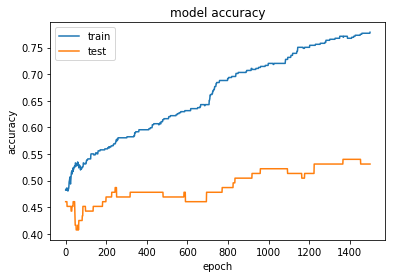

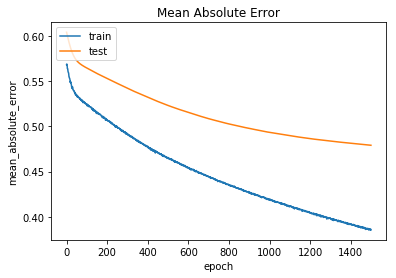

In [9]:
fitted_model = fittedModel
# list all data in history
print(fitted_model.history.keys())
# summarize history for accuracy
plt.plot(fitted_model.history['acc'])
plt.plot(fitted_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for root mean squared error
plt.plot(fitted_model.history['rmse'])
plt.plot(fitted_model.history['val_rmse'])
plt.title('Mean Absolute Error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
## End of implementation code  

print('Printing environment settings')

from platform import python_version
print('\nPython version: ', python_version())
print('\nInstalled modules:\n')

!pip freeze

Printing environment settings

Python version:  3.7.1

Installed modules:

absl-py==0.7.1
alabaster==0.7.12
altgraph==0.16.1
anaconda-client==1.7.2
anaconda-navigator==1.9.6
anaconda-project==0.8.2
asn1crypto==0.24.0
astor==0.8.0
astroid==2.1.0
astropy==3.1
atomicwrites==1.2.1
attrs==18.2.0
Babel==2.6.0
backcall==0.1.0
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==3.0.2
blis==0.2.4
bokeh==1.0.2
boto==2.49.0
boto3==1.9.169
botocore==1.12.169
Bottleneck==1.2.1
cachetools==3.1.1
certifi==2018.11.29
cffi==1.11.5
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
clyent==1.2.2
colorama==0.4.1
colorlover==0.3.0
comtypes==1.1.7
conda==4.5.12
conda-build==3.17.6
conda-verify==3.1.1
contextlib2==0.5.5
cryptography==2.4.2
cufflinks==0.15
cycler==0.10.0
cymem==2.0.2
Cython==0.29.2
cytoolz==0.9.0.1
dask==1.0.0
datashape==0.5.4
decorator==4.3.0
defusedxml==0.5.0
distributed==1.25.1
docutils==0.14
entrypoints==0.2.3
